# Explore regridding

This notebook an additional place for exploring the regridding options via xESMF, particularly the NaN problem.

In [50]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

from config import (
    target_grid_fp,
    cmip6_dir,
    SCRATCH_DIR,
    model_inst_lu,
    transfers_config,
)

# ignore serializationWarnings from xarray for datasets with multiple FillValues
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

### How is xESMF handling nodata

It looks like the NaNs are treated as numbers in xESMF, and we will likely need to modify the datasets with masks to achieve the desired regridding. We will try adding `mask` variables to the source and destination datasets. That means we will need the masked version of the data for the target dataset as well, so we will pull the same variable instead of `tas`.

In [51]:
mrro_target_grid_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Lmon/mrro/gn/v20190815/mrro_Lmon_CESM2-WACCM_ssp370_r1i1p1f1_gn_201501-206412.nc"
)

dst_ds = xr.open_dataset(mrro_target_grid_fp)
lon_enc = dst_ds["lon"].encoding
lon_attrs = dst_ds["lon"].attrs
# subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
dst_ds.coords["lon"] = (dst_ds.coords["lon"] + 180) % 360 - 180
dst_ds["lon"].encoding = lon_enc
dst_ds["lon"].attrs = lon_attrs
# sort and verify
dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)

# lets just work on one time slice, on a bbox near the coast
dst_ds = dst_ds.isel(time=[10])

Here is an example with a source data file already on the target grid, and so we would expect values to match exactly, but they clearly don't:

In [52]:
model = "CESM2-WACCM"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])

Text(0.5, 1.0, 'regridded data')

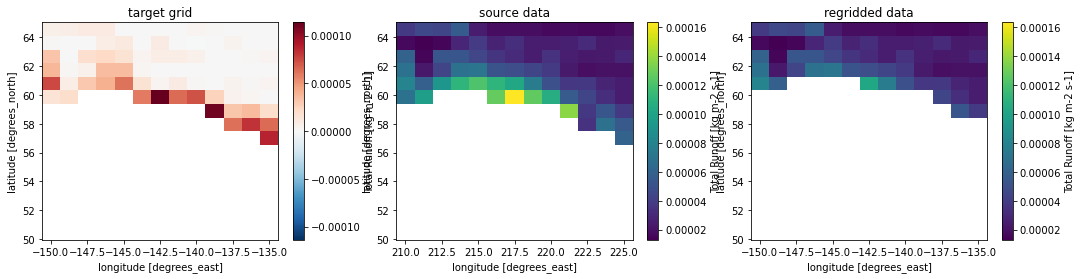

In [53]:
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)


ax[0].set_title("target grid")
ax[1].set_title("source data")
ax[2].set_title("regridded data")

Try adding `mask` variables to each dataset individually. (Note that for mask, the ESMF convention is used, where masked values are identified by 0, and non-masked values by 1.)

First, try the `mask` variables on the source dataset only (ie, the data to be regridded).

Text(0.5, 1.0, 'regridded data')

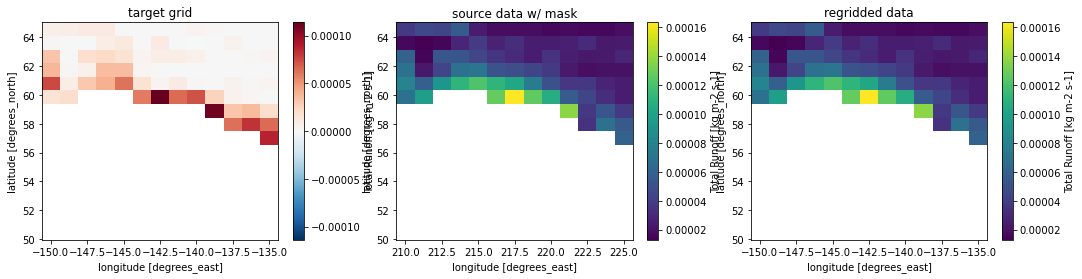

In [54]:
# add mask to the source dataset (to be regridded)
src_ds["mask"] = xr.where(~np.isnan(src_ds[var_id]), 1, 0).isel(time=0)

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid")
ax[1].set_title("source data w/ mask")
ax[2].set_title("regridded data")

They look the same - are they the same?

In [55]:
assert np.array_equal(
    src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)),
    regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)),
    equal_nan=True,
)

Sure are!


Now, try the `mask` variables on the destination dataset only (ie, the target grid).

Text(0.5, 1.0, 'regridded data')

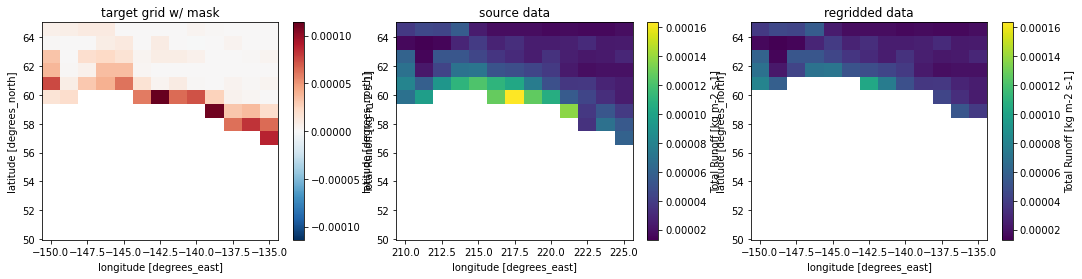

In [56]:
dst_ds["mask"] = xr.where(~np.isnan(dst_ds[var_id]), 1, 0).isel(time=0)

regridder = xe.Regridder(
    src_ds.drop_vars("mask"), dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data")
ax[2].set_title("regridded data")

That does not appear to work.
Now, try the `mask` variables on both source and destination datasets:

Text(0.5, 1.0, 'regridded data')

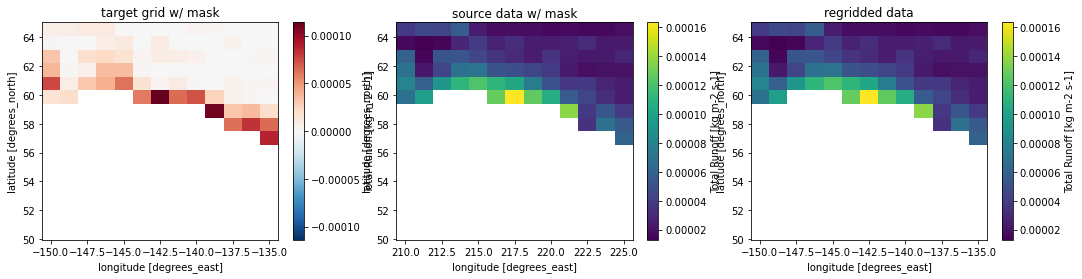

In [57]:
#both src_ds and dst_ds have a mask variable now...
regridder = xe.Regridder(
    src_ds, dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data w/ mask")
ax[2].set_title("regridded data")

That also works! 
Now it is worth checking what things would look like for both options with a dataset that is not already on the target grid:

In [58]:
model = "GFDL-ESM4"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])
src_ds["mask"] = xr.where(~np.isnan(src_ds[var_id]), 1, 0).isel(time=0)


Including `mask` variable to the source dataset only:

Text(0.5, 1.0, 'regridded data')

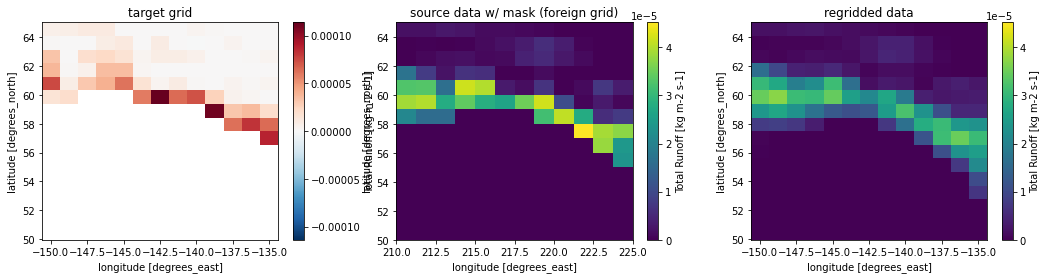

In [59]:
regridder = xe.Regridder(
    src_ds, dst_ds.drop_vars("mask"), "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid")
ax[1].set_title("source data w/ mask (foreign grid)")
ax[2].set_title("regridded data")

The GFDL data appears to use 0 over the oceans for this `mrro` variable, so the NaN mask had no effect there, and the NaNs from the target grid were not propagated into the regridded dataset. 

Now try including `mask` variable to the destination dataset only:

Text(0.5, 1.0, 'regridded data')

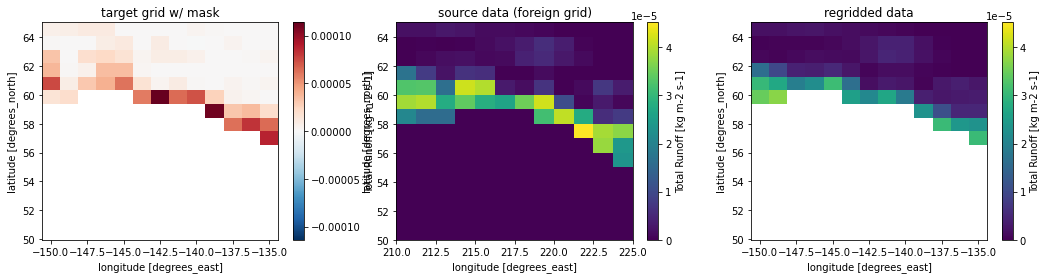

In [60]:
regridder = xe.Regridder(
    src_ds.drop_vars("mask"), dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data (foreign grid)")
ax[2].set_title("regridded data")

That clearly pushes NaN values from the target grid into the regridded dataset, overwriting all of those zeroes in the source datas set.

Now try including `mask` variable to both datasets:

Text(0.5, 1.0, 'regridded data')

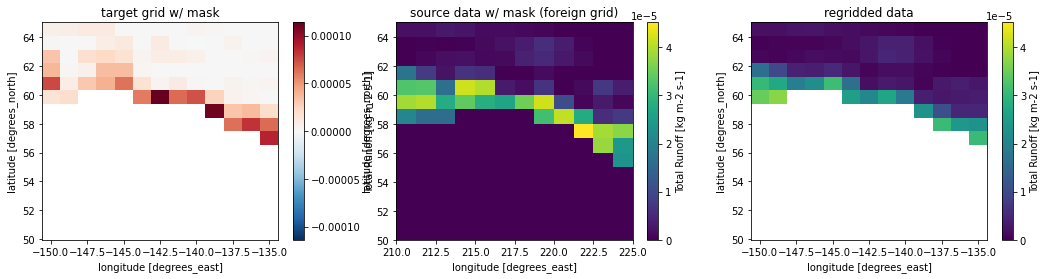

In [61]:
regridder = xe.Regridder(
    src_ds, dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data w/ mask (foreign grid)")
ax[2].set_title("regridded data")


So it looks like the safest bet is to add a `mask` variable to the both source and destination datasets. If source and destination are on the same grid (and therfore share locations for NaN values), this will prevent the regridder from propagating NaNs into the actual data values. If source and destination are on different grids, the NaN values of the destination grid will "overrule" any values in the source dataset.

As far as implementing this programmatically, we may need to define the destination dataset based on the given variable of the source dataset. Land-only variables in our target grid seem to include NaNs in the ocean, while some of the other datasets do not (like in the GFDL data above).

Also, we see below that the `mask` variable persists in the regridded output, so we should probably drop that variable before writing the .nc file.

In [62]:
regrid_ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 192, lon: 288, bnds: 2)
Coordinates:
  * bnds     (bnds) float64 1.0 2.0
  * time     (time) object 2015-11-16 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Data variables:
    mrro     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mask     (lat, lon) int64 -9223372036854775808 ... -9223372036854775808
Attributes: (12/47)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Lmon
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    ...                     ...
    tracking_id:            hdl:21.14100/685cc699-3589-4c78-b04b-d275a3257c7b
    variable_id:            mrro
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    regrid_method:          bilinear

### Incorporating extrapolation/interpolation during regridding of NaNs

How does xESMF behave when performing extrapolation during the regridding function? Let's try that last example again, but using some extrapolation paramaters. Do the NaNs get overwritten with extrapolated values, or is the mask still honored in the output?

Text(0.5, 1.0, 'regridded data w/ extrapolation')

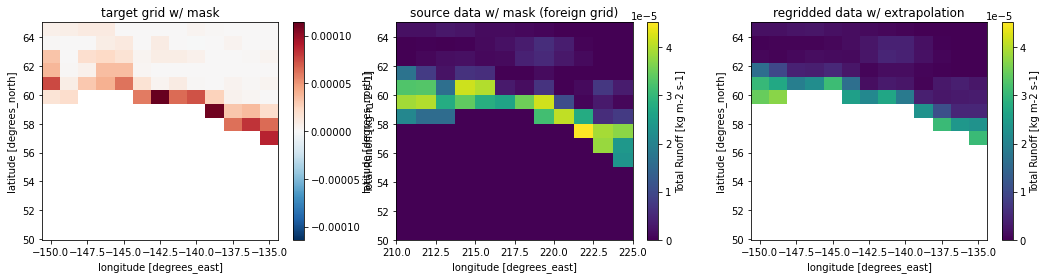

In [63]:
#using extrapolate
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True, extrap_method="nearest_s2d")

regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data w/ mask (foreign grid)")
ax[2].set_title("regridded data w/ extrapolation")

Text(0.5, 1.0, 'regridded data with periodic=True')

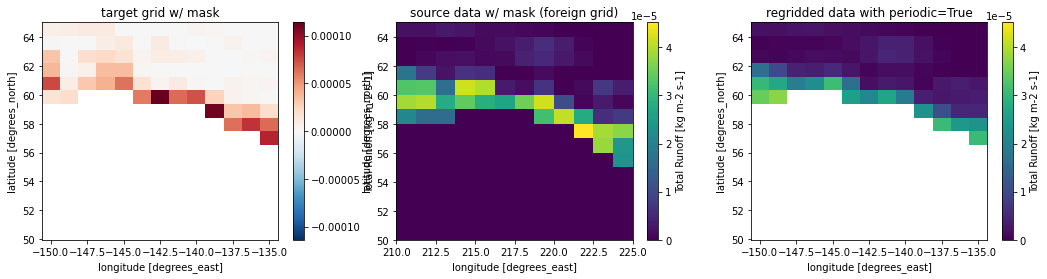

In [64]:
#using periodic
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True, periodic=True)

regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data w/ mask (foreign grid)")
ax[2].set_title("regridded data with periodic=True")

It looks like the NaN mask is honored, even when we call for extrapolation.

### Using a continuous target grid (no land/ocean mask)

As another option, let's go back to using the global `tas` variable as the target grid, while continuing to use a land-only variable `mrro` as the source dataset. We can see that the masks don't really have an effect here, since the target grid is continuous (no NAs) and the GFDL source data, even though its a land-only variable, uses 0 in the oceans instead of NaN. So those zero values are carried into the new regridded dataset. This is a case which might require a land/ocean mask to be applied after the fact.

In [46]:
dst_ds = xr.open_dataset(target_grid_fp)
lon_enc = dst_ds["lon"].encoding
lon_attrs = dst_ds["lon"].attrs
# subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
dst_ds.coords["lon"] = (dst_ds.coords["lon"] + 180) % 360 - 180
dst_ds["lon"].encoding = lon_enc
dst_ds["lon"].attrs = lon_attrs
# sort and verify
dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)

# lets just work on one time slice, on a bbox near the coast
dst_ds = dst_ds.isel(time=[10])

Text(0.5, 1.0, 'regridded data')

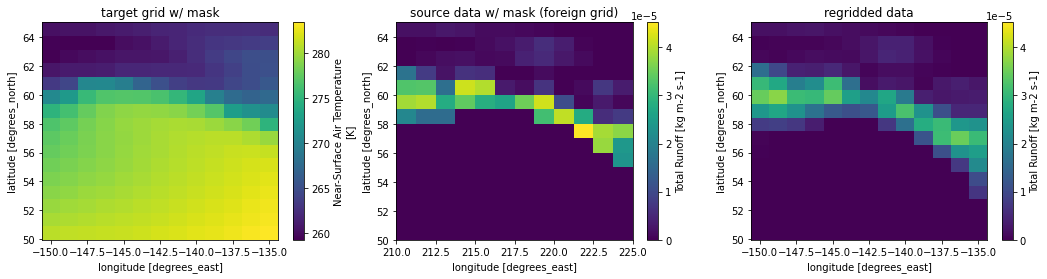

In [47]:
regridder = xe.Regridder(
    src_ds, dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
vmin, vmax = src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).min(), src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).max()
dst_ds["tas"].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[0])
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[1], vmin=vmin, vmax=vmax)
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

ax[0].set_title("target grid w/ mask")
ax[1].set_title("source data w/ mask (foreign grid)")
ax[2].set_title("regridded data")

There are implications if using the method above, that for some land-only variables there will be NaNs in the oceans and for others there will be zeros. This affects our idea for a "common grid" between models, and masking to a common extent may need to be variable-specific instead of applied across all models/variables.